LST grid: 
  CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] 
  shape: (34, 65) 
  transform: | 926.63, 0.00,-6407614.87|
| 0.00,-926.63, 4876829.65|
| 0.00, 0.00, 1.00|

NDVI (original) grid: 
  CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] 
  shape: (133, 257) 
  transform: | 231.66, 0.00,-6407383.21|
| 0.00,-231.66, 4876598.00|
| 0.00,

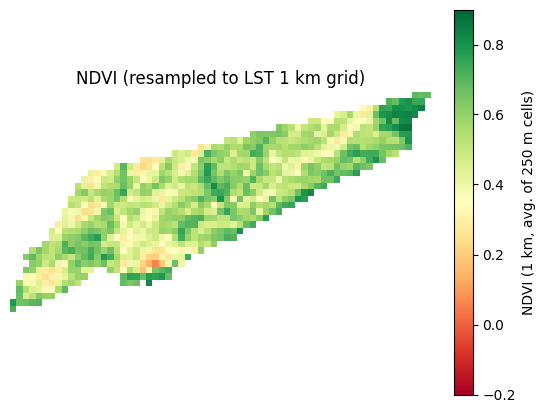

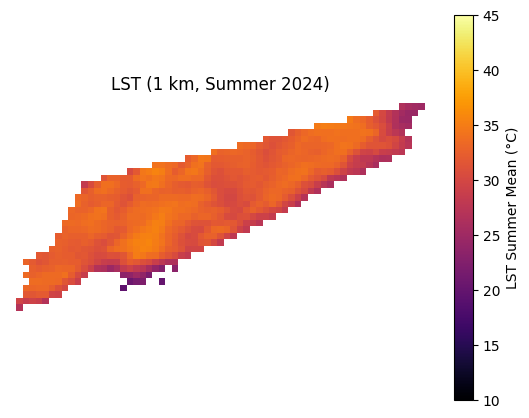

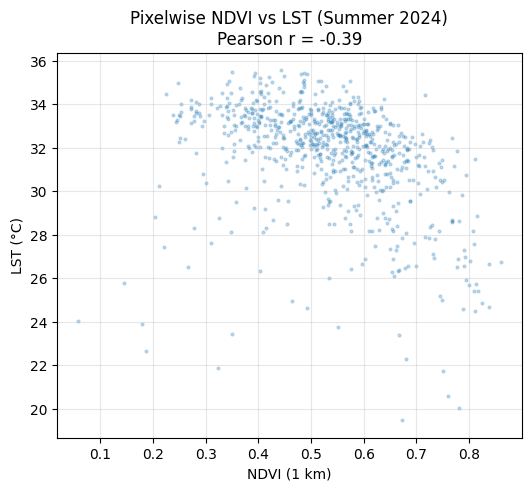

In [ ]:
NDVI_SINU = "../data/processed/ndvi_clean/ndvi_summer_2024_mean_sinusoidal.tif"
LST_SINU  = "../data/processed/lst_clean/lst_summer_2024_mean_sinusoidal.tif"
OUT_NDVI_1KM = "../data/processed/ndvi_clean/ndvi_summer_2024_mean_1km_match_lst.tif"

import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt

# Open LST grid --> 1km target
with rasterio.open(LST_SINU) as lst:
    lst_arr       = lst.read(1)
    dst_crs       = lst.crs
    dst_transform = lst.transform
    dst_height    = lst.height
    dst_width     = lst.width
    dst_profile   = lst.profile

print("LST grid:",
      "\n  CRS:", dst_crs,
      "\n  shape:", (dst_height, dst_width),
      "\n  transform:", dst_transform)

# Open NDVI grid --> 250m
with rasterio.open(NDVI_SINU) as ndvi:
    ndvi_arr      = ndvi.read(1)         
    src_crs       = ndvi.crs
    src_transform = ndvi.transform

print("\nNDVI (original) grid:",
      "\n  CRS:", src_crs,
      "\n  shape:", ndvi_arr.shape,
      "\n  transform:", src_transform)

# data resampling using area average
ndvi_1km = np.full((dst_height, dst_width), np.nan, dtype="float32")

reproject(
    source = ndvi_arr,
    destination = ndvi_1km,
    src_transform = src_transform,
    src_crs = src_crs,
    dst_transform = dst_transform,
    dst_crs = dst_crs,
    resampling = Resampling.average,
    src_nodata = np.nan,
    dst_nodata = np.nan,
)

out_profile = dst_profile.copy()
out_profile.update({"dtype": "float32", "nodata": np.nan})
with rasterio.open(OUT_NDVI_1KM, "w", **out_profile) as dst:
    dst.write(ndvi_1km, 1)
print("\n✅ Wrote aligned NDVI (1 km):", OUT_NDVI_1KM)

# 5) Quick sanity facts after alignment
print("\nSanity checks:",
      "\n  NDVI_1km shape == LST shape? ", ndvi_1km.shape == lst_arr.shape,
      "\n  NDVI_1km finite %:", f"{np.isfinite(ndvi_1km).mean()*100:.1f}%",
      "\n  LST finite %:",      f"{np.isfinite(lst_arr).mean()*100:.1f}%")

plt.figure(figsize=(6,5))
im = plt.imshow(ndvi_1km, vmin=-0.2, vmax=0.9, cmap="RdYlGn")
plt.colorbar(im, fraction=0.046, label="NDVI (1 km, avg. of 250 m cells)")
plt.title("NDVI (resampled to LST 1 km grid)")
plt.axis("off")
plt.show()

plt.figure(figsize=(6,5))
vmin, vmax = 10, 45  # typical summer daytime surface temps for visualization
im = plt.imshow(lst_arr, vmin=vmin, vmax=vmax, cmap="inferno")
plt.colorbar(im, fraction=0.046, label="LST Summer Mean (°C)")
plt.title("LST (1 km, Summer 2024)")
plt.axis("off")
plt.show()

mask = np.isfinite(ndvi_1km) & np.isfinite(lst_arr)
x = ndvi_1km[mask].ravel()
y = lst_arr[mask].ravel()

if x.size > 100000:  # subsample for speed/clarity
    idx = np.random.choice(x.size, 100000, replace=False)
    x = x[idx]; y = y[idx]

corr = np.corrcoef(x, y)[0,1] if x.size > 1 else np.nan
plt.figure(figsize=(6,5))
plt.scatter(x, y, s=4, alpha=0.25)
plt.xlabel("NDVI (1 km)")
plt.ylabel("LST (°C)")
plt.title(f"Pixelwise NDVI vs LST (Summer 2024)\nPearson r = {corr:.2f}")
plt.grid(True, alpha=0.3)
plt.show()

